# Training a dense neural network

The handwritten digit recognition is a classification problem. We will start with the simplest possible approach for image classification - a fully-connected neural network (which is also called a *perceptron*). First, let's start with quickly loading and normalizing the dataset, as we have done in the previous unit:

In [2]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
import os

In [3]:
# Pre-fetch the data when running in sandbox environment
!mkdir -p data
!wget -O data/mnist.npz -q https://github.com/MicrosoftDocs/tensorflow-learning-path/raw/main/data/mnist.npz
path = os.path.join(os.getcwd(),'data','mnist.npz')

In [4]:
(x_train,y_train),(x_test,y_test) = keras.datasets.mnist.load_data(path=path) 
# you may omit path parameter when running locally

x_train = x_train.astype(np.float32) / 255.0
x_test = x_test.astype(np.float32) / 255.0

## Fully-connected dense neural networks

A basic **neural network** consists of a number of **layers**. The simplest network would include just one fully-connected layer, which is called **Dense** layer, with 784 inputs (one input for each pixel of the input image) and 10 outputs (one output for each class). It is called dense because it contains all possible connections between 784 inputs and 10 outputs, 7840 total connections.

![Dense Neural Network Structure](./images/dense-onelayer-network.png)

As we discussed above, the dimension of our digit images is $28\times28$. Because the input dimension of a fully-connected layer is 784, we need to insert another layer into the network, called **Flatten**, to change tensor shape from $28\times28$ to $784$. We could have also changed

We want $n$-th output of the network to return the probability of the input digit being equal to $n$. Because the output of a fully-connected layer is not normalized to be between 0 and 1, it cannot be thought of as probability. To turn it into a probability we need to apply another layer called **Softmax**.

In PyTorch, it is easier to use **LogSoftmax** function, which will also compute logarithms of output probabilities. To turn the output vector into the actual probabilities, we need to take **torch.exp** of the output. 

Thus, the architecture of our network can be represented by the following sequence of layers:

![An image showing the architecture of the network broken into a sequence of layers.](./images/onelayer-network-layers.png)

It can be defined in Keras in the following way, using `Sequential` syntax:

In [2]:
model = keras.models.Sequential([
        keras.layers.Flatten(input_shape=(28,28)), 
        keras.layers.Dense(10,activation='softmax')])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 10)                7850      
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________


Once you have defined a network, you can call `summary` method to display its artchitecture, together with some other useful information, such as number of parameters in each layer.

When defining a network, it is important to remember to specify the dimension of the input tensor in `input_shape` parameter. If you do not do that, Keras is unable to understand how many neurons are required to construct each layer. It is possible to omit `input_shape` parameter, and the network would be initialized when you first start training it, but it would not be as easy to call `summary` and other similar methods, because you would need to specify the input size there.

## Anatomy of a Dense Layer

I have mentioned above that a dense layer contains 7840 weighted connections, however, in the `summary` above we see that our dense layer has 7850 parameters. Let's take some time to understand why.

Network input contains 784 pixels, which can be represented by a vector $x$ with 784 numbers ($x\in\mathbb{R}^{784}$). To get an output $z$ of dimension 10 we can multiply it by a matrix $W$ with dimensions $10\times784$: $z=W\times x$.

However, such multiplication defines a linear transformation without shift. Imagine we had only one input value, then the matrix would have just one weight, and the equation $W\times x$ would represent a straight line which goes through the point $(0,0)$. Such a line would not be able to perform arbitrary classifications, because in some cases we also want some **shift** to happen. That means that we need a full equation for a straight line: $z=W\times x + b$, where $b$ is so-called **bias**.

Similarly, in a dense layer with 784 inputs and 10 outputs, the output would be calculated as $W\times x + b$, where the dimension of **weight** matrix $W$ is $784\times 10$, and the dimension of a **bias** vector $b$ is 10. This gives us $784\times 10 + 10 = 7850$ parameters. 

In Keras, we can get the weight matrix and bias from `layers` property. Our dense layer is a second layer from the top, thus it can be access using `model.layers[1]`.

In [16]:
model.layers[1].weights

[<tf.Variable 'dense_1/kernel:0' shape=(784, 10) dtype=float32, numpy=
 array([[-0.02826056,  0.02360517, -0.05109077, ...,  0.05689304,
          0.02262866, -0.02827531],
        [ 0.02178557, -0.01677105,  0.06298711, ..., -0.07144041,
         -0.04397168, -0.00610393],
        [-0.01917727,  0.02283786, -0.0311489 , ...,  0.00351296,
         -0.03494745, -0.01451694],
        ...,
        [-0.02218518, -0.06369236,  0.06964662, ..., -0.04079114,
          0.02219214,  0.0707586 ],
        [ 0.0549698 ,  0.02553204, -0.03380113, ...,  0.03810661,
         -0.00137232,  0.04822978],
        [-0.0470043 ,  0.03090737,  0.0858553 , ..., -0.0494021 ,
         -0.08495053,  0.03962546]], dtype=float32)>,
 <tf.Variable 'dense_1/bias:0' shape=(10,) dtype=float32, numpy=
 array([-0.20568545,  0.27014664,  0.00803099, -0.16003485,  0.07587552,
         0.6701165 , -0.02943662,  0.34646973, -0.844504  , -0.1309774 ],
       dtype=float32)>]

As you can see, `weights` property of a layer returns a list of all weights, in our case it is the actual weight matrix called **kernel**, and a **bias**.

## Training the network

A network defined this way can take any digit as input and produce a vector of probabilities as an output. Let's see how this network performs by giving it a digit from our dataset:

In [3]:
print('Digit to be predicted: ',y_train[0])
model(np.expand_dims(x_train[0],0))

Digit to be predicted:  5


<tf.Tensor: shape=(1, 10), dtype=float32, numpy=
array([[0.05053953, 0.09909543, 0.03949523, 0.16483502, 0.14355619,
        0.08681724, 0.09538525, 0.05725125, 0.18585688, 0.07716793]],
      dtype=float32)>

The ouput of the network is so-called **tensor**, represented by `ft.Tensor` object. It is very similar to numpy array, with the difference that Tensorflow can operate on tensors very efficiently, shifting computetions to GPU when appropriate.

> **Note**: In fact, low-level Tensorflow API contains all basic tensor operations, similar to corresponding numpy operations on arrays. For example, you can use `tf.exp` on tensors, and it would be equivalent to calling `np.exp` on numpy arrays.

As you can see the network predicts very similar probabilities for each digit. This is because it has not been trained on how to recognize the digits. We need to give it our training data to train it on our dataset.

To train the model we first need to **compile** it:

In [4]:
model.compile(optimizer='sgd',loss='categorical_crossentropy')

When compiling a model, we specify two important things:
* An **optimizer** that will be used to minimize the error. The simplest optimized is **stochastic gradient descent**, or SGD; but with more complex networks other optmizers are often used, such as **Adam**
* A **loss function** that we will be using. This function will be used on the output of the network to obtain the error, which we will then minimize. Since the output of our network is probabilitiy of digits, and we have **multi-class classification** problem, we will use **categorical cross-entropy** as loss.

To train the network, we need to provide output for each training sample. Because out network outputs probabilities for each digit from 0 to 9, we need expected outputs to have the same layout, i.e. be a 10-number vector that contains 1 in only one position. This is called **one-hot encoding**. For example, digit 5 will be one-hot-encoded by a vector (0 0 0 0 0 1 0 0 0 0).

We can easily one-hot-encode training labels using Keras API:

In [5]:
y_train_onehot = keras.utils.to_categorical(y_train)
y_test_onehot = keras.utils.to_categorical(y_test)
print("First 3 training labels:",y_train[:3])
print("One-hot-encoded version:\n",y_train_onehot[:3])

First 3 training labels: [5 0 4]
One-hot-encoded version:
 [[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]


Now, to do the actual training, we just need to call one `fit` function:

In [6]:
model.fit(x_train,y_train_onehot)

Train on 60000 samples
60000/60000 [==============================] - 4s 58us/sample - loss: 0.7685


## Monitoring training

This training only loops through the dataset once, which is called one **epoch**. Normally we want training to go on for several epochs, and we can specify the number of epochs we want using a parameter.

Also, it is useful to evaluate the quality of the model on test (or validation) dataset, because the model generally performs worse on the data that it has never seen, and it can indicate us how well the model **generalizes** to other data beyond our dataset. To evaluate validation error in between epochs, we can pass test data as well:

In [7]:
hist = model.fit(x_train,y_train_onehot,validation_data=(x_test,y_test_onehot), epochs=3)

Train on 60000 samples, validate on 10000 samples
Epoch 1/3
60000/60000 [==============================] - 4s 69us/sample - loss: 0.4534 - val_loss: 0.3974
Epoch 2/3
60000/60000 [==============================] - 4s 68us/sample - loss: 0.4014 - val_loss: 0.3651
Epoch 3/3
60000/60000 [==============================] - 4s 69us/sample - loss: 0.3753 - val_loss: 0.3464


`fit` function returns so-called **history** object that contains the data on obtained loss during each training epoch. It can be used to visualize the loss on the graph:

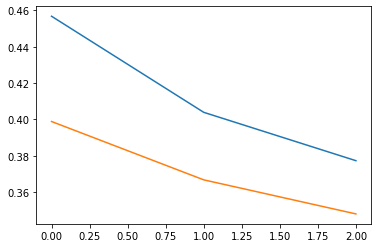

In [50]:
for x in ['loss','val_loss']:
    plt.plot(hist.history[x])

## Metrics and Minibatches

The value of loss function does not tell us a lot about the accuracy of the model. To measure accuracy, we would probably want to see the percentage of correctly classified digits from the test dataset. In fact, we can add accuracy as a **metric** during dataset compilation, and it would be displayed and reported all the way through the training:

In [8]:
model.compile(optimizer='sgd',loss='categorical_crossentropy',metrics=['acc'])
hist = model.fit(x_train,y_train_onehot,validation_data=(x_test,y_test_onehot), epochs=3,batch_size=128)

Train on 60000 samples, validate on 10000 samples
Epoch 1/3
60000/60000 [==============================] - 2s 26us/sample - loss: 0.3629 - acc: 0.9003 - val_loss: 0.3431 - val_acc: 0.9074
Epoch 2/3
60000/60000 [==============================] - 1s 20us/sample - loss: 0.3592 - acc: 0.9012 - val_loss: 0.3395 - val_acc: 0.9082
Epoch 3/3
60000/60000 [==============================] - 1s 19us/sample - loss: 0.3558 - acc: 0.9020 - val_loss: 0.3369 - val_acc: 0.9091


In addition to using new accuracy metrics, we have specified `batch_size` parameter to define the number of samples that are being processed by the neural network at once. Since GPU computations are easily parallelizable, it is much more efficient to process several samples in one go. Larger minibatch size significantly speeds up learning process, as you may have noticed in our example, but also makes it a little bit less precise, due to the fact that direction of optimization is selected for the whole minibatch, and not for each individual sample. Thus, choosing minibatch size is quite tricky, and it remains one of the hyperparameters that can be further optimized to achieve better performance. 

## Specifying Optimizer Parameters

In the previous call to `compile`, we have been specifying optimizer, loss and metrics using keyword abbreviations, such as `sgd`. However, sometimes we might want to do some fine-tuning to optimizer parameters, or use custom loss function. In such cases, it is possible to pass objects instead of string abbreviations.

Let's use a variation of stochastic gradient descent, which is called **momentum SGD**. The idea is that the gradients of loss function will be averaged over the last few steps in order to keep the momentum, and make optimization more smooth. To turn our gradient descent into momentum SGD, we need to create `SDG` optimizer object explicitly, provide `momentum` parameter, and pass this object to `compile` method.

In [9]:
model = keras.models.Sequential([
        keras.layers.Flatten(input_shape=(28,28)), 
        keras.layers.Dense(10,activation='softmax')])
model.compile(optimizer=keras.optimizers.SGD(momentum=0.5),loss='categorical_crossentropy',metrics=['acc'])
hist = model.fit(x_train,y_train_onehot,validation_data=(x_test,y_test_onehot), epochs=10, batch_size=64)  

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 2s 35us/sample - loss: 0.7886 - acc: 0.8094 - val_loss: 0.4813 - val_acc: 0.8790
Epoch 2/10
60000/60000 [==============================] - 2s 33us/sample - loss: 0.4570 - acc: 0.8803 - val_loss: 0.4001 - val_acc: 0.8947
Epoch 3/10
60000/60000 [==============================] - 2s 39us/sample - loss: 0.4039 - acc: 0.8918 - val_loss: 0.3677 - val_acc: 0.9031
Epoch 4/10
60000/60000 [==============================] - 2s 39us/sample - loss: 0.3773 - acc: 0.8972 - val_loss: 0.3480 - val_acc: 0.9058
Epoch 5/10
60000/60000 [==============================] - 2s 40us/sample - loss: 0.3605 - acc: 0.9013 - val_loss: 0.3360 - val_acc: 0.9093
Epoch 6/10
60000/60000 [==============================] - 2s 39us/sample - loss: 0.3485 - acc: 0.9035 - val_loss: 0.3263 - val_acc: 0.9121
Epoch 7/10
60000/60000 [==============================] - 2s 40us/sample - loss: 0.3395 - acc: 0.9061 - val_loss: 0.

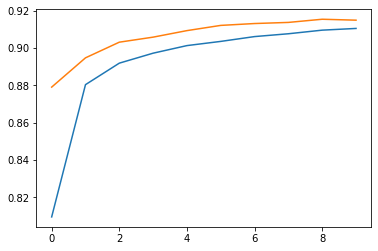

In [10]:
for x in ['acc','val_acc']:
    plt.plot(hist.history[x])

## Visualizing network weights

Now let's visualize the weights of our neural network and see what they look like. When the network is more complex than just one layer, making sense of the weight data is more difficult. However, in our case, classification of a digit in one-layered perceptron happens by multiplying the initial image by a weight matrix, which allows us to visualize the network weights and see if they make any sense.

Let's create a `weight_tensor` which will have a dimension of 784x10. This tensor can be obtained by calling the `net.parameters()` method. In this example, if we want to see if our number is 0 or not, we will multiply input digit by `weight_tensor[0]` and pass the result through a softmax normalization to get the answer. This results in the weight tensor elements somewhat resembling the average shape of the digit it classifies:

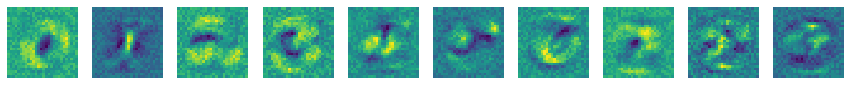

In [11]:
weight_tensor = model.layers[1].weights[0].numpy().reshape(28,28,10)
fig,ax = plt.subplots(1,10,figsize=(15,4))
for i in range(10):
    ax[i].imshow(weight_tensor[:,:,i])
    ax[i].axis('off')

## Takeaway 

Training a neural network in Keras requires just one line of code and tweaking a few parameters. Defining a network is also quite simple, but you need to know which layers to use. We will talk more about that in the next units.

We can see that a single-layer dense neural network shows relatively good performance, but we definitely want to get higher than 91% on accuracy! In the next unit, we will try to use multi-level perceptrons.